In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.pylab as pylab
import cartopy.feature as cfeature
import scipy.stats as stats
import xarray as xr
import ipdb
import glob
import itertools
import numpy.ma as ma
from utils import u_statistics as u_stat
from scipy.stats import gaussian_kde, linregress
import pickle as pkl
from utils import u_plot as uplot, u_darrays as uda, u_met
import pandas as pd

##for regridding, install xesmf:
# conda install esmpy
# pip install xesmf
from utils import constants as cnst

pylab.rcParams['figure.figsize'] = (30., 30.)
#%matplotlib inline

In [2]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [4]:
era_all = pkl.load(open (cnst.CLOVER_SAVES + 'StormLoc_-50_5000km_WA_ERA5_allmonth_2000-2014_18UTC_front.p', 'rb'))
era_clim = pkl.load(open (cnst.CLOVER_SAVES + 'StormLoc_-50_5000km_WA_ERA5_allmonth_2000-2014_18UTC_front_CLIM.p', 'rb'))

In [75]:
def get_col(var):
    vdic = {}
    vdic['low'] = []
    vdic['high'] = []
    vdic['mean'] = []
    for v in var:
        
        vdic['low'].append(v.flatten()[16])
        vdic['high'].append(v.flatten()[12])
        vdic['mean'].append(np.array(v).flatten().mean())        
    return vdic

In [57]:
def get_q(var):
    vdic = {}
    vdic['low'] = []
    for v in var:
        
        vdic['low'].append(np.array(v[12:16]).sum())
     
    return vdic

In [7]:
np.median(era_all['q_col'])

0.005772334

In [19]:
dq_s = np.array(era_all['q925_s'])*1000-np.array(era_clim['q925_s'])*1000
dq = np.array(era_all['q925'])*1000-np.array(era_clim['q925'])*1000

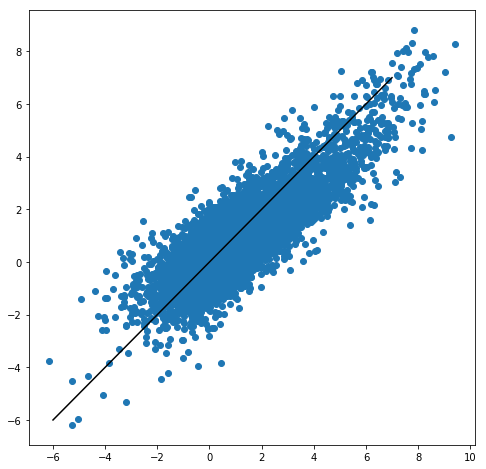

In [20]:
plt.figure(figsize=(8,8))
plt.scatter(np.array(era_all['q925_s'])*1000-np.array(era_clim['q925_s'])*1000, np.array(era_all['q925'])*1000-np.array(era_clim['q925'])*1000)
plt.plot(np.arange(-6,8), np.arange(-6,8), 'k')

In [96]:
diff = dq_s*1000-dq*1000
print(np.sum(diff>0))
print(np.sum(diff<0))

10328
8550


In [22]:
level = era_all.pop('level')
level = era_clim.pop('level')

In [64]:
level = level[0:19]

In [67]:
era_clim['q_col']

[array([[3.9489740e-05, 1.1924788e-04, 2.3816864e-04, 4.3570247e-04,
         7.3707080e-04, 1.1602788e-03, 1.7479210e-03, 2.4728791e-03,
         3.2757709e-03, 4.3651368e-03, 5.5128061e-03, 6.5415697e-03,
         9.3887737e-03, 1.0774128e-02, 1.2393387e-02, 1.3877487e-02,
         1.4935643e-02, 1.5334897e-02, 1.5519672e-02]], dtype=float32),
 array([[3.8076574e-05, 1.1947793e-04, 2.5531478e-04, 4.8610501e-04,
         8.3726941e-04, 1.2951724e-03, 1.9522104e-03, 2.7736903e-03,
         3.4955908e-03, 4.3798652e-03, 5.4095890e-03, 6.3119787e-03,
         8.9622643e-03, 1.0079058e-02, 1.1106490e-02, 1.2146263e-02,
         1.3662082e-02, 1.5522518e-02, 1.6207635e-02]], dtype=float32),
 array([[3.80046513e-05, 1.05905936e-04, 2.01373943e-04, 3.63209838e-04,
         6.07776281e-04, 9.46827233e-04, 1.49922888e-03, 2.15011253e-03,
         3.00814048e-03, 4.07268433e-03, 5.28874155e-03, 6.16760645e-03,
         7.69206230e-03, 9.04999953e-03, 1.15747610e-02, 1.33773452e-02,
         1.4

In [194]:
era_all_qsum = get_q(era_all['q_col'])
era_all['q_col_sum'] = era_all_qsum['low']
era_all_qsum_storm = get_q(era_all['q_col_s'])
era_all['q_col_sum_s'] = era_all_qsum_storm['low']

In [24]:
era_new = era_all.copy()
octt = era_all.copy()
marchh = era_all.copy()

In [80]:
for k in era_all.keys():
    print(k)
#     if k == 'dates':
#         continue
    varlist = []
    varo = []
    varm = []
    for ids, ise in enumerate(era_all[k]):
        
        if k in ['tmean', 'tmin', 't10', 'area', 'area70']:
            diff = np.array(ise)
        else:
            diff = np.array(ise)-np.array((era_clim[k])[ids])
        
        if (era_all['dates'][ids].month <=6) | (era_all['dates'][ids].month >=9):
            varlist.append(diff)
        if era_all['dates'][ids].month == 3:
            varm.append(diff)
        if era_all['dates'][ids].month == 10:
            varo.append(diff)
    era_new[k] = np.array(varlist)          
    octt[k] = np.array(varo)
    marchh[k] = np.array(varm)

lon
u_col
u_col_s
u925
area70
u925_s
q_col_s
u650_s
tmean
tcwv_s
u650
v_col_s
q_col
r_col_s
lat
q925
t10
q700_s
tmin
CAPE
v_col
dates
q700
area
tcwv
q925_s
CAPE_s
r_col


In [81]:
qmsort = np.argsort(marchh['q925'])
qm = marchh['q925'][qmsort]

In [82]:
marchh['u_col'][10]

array([[-0.22860718, -2.602788  ,  0.19386196, -1.3205466 , -0.01871008,
         0.56719923, -1.9327419 , -3.8632216 ,  0.24081278, -1.3158913 ,
        -3.524374  , -4.4995346 , -0.85203075,  1.2376626 ,  0.96227944,
         0.43012714,  0.295519  ,  0.2537415 ,  0.1719765 ]],
      dtype=float32)

In [83]:
level[16]

925

In [86]:
def sort_vars(dic):
    q925 = np.array(dic['q925'])
    q925s = np.array(dic['q925_s'])
    
    udic = get_col(dic['u_col'])
    vdic = get_col(dic['v_col'])
    #ipdb_set_trace()
    ushear =(np.array(udic['high'])-np.array(udic['low']))
    vshear = (np.array(vdic['high'])-np.array(vdic['low']))
    
    #ipdb.set_trace()
    
    shearss = u_met.u_v_to_ws_wd(ushear, vshear)
    
    shears = shearss[0]
    #shears = np.array(dic['u650']) - np.array(dic['u925']) #shearss[0]
    q925 = q925 #(q925s-
    sort = np.argsort(q925)
    q = q925[sort]*1000
    shear = shears[sort]
    tmin = np.array(dic['tmin'])[sort]
    linsp = np.linspace(0,len(q)-1,10)
    
    inds = np.round(linsp).astype(int)
    #ipdb.set_trace()
    f=plt.figure(figsize=(13,9))
    ax = f.add_subplot(311)
    plt.plot(q)
    #plt.ylim(8,18)
    ax = f.add_subplot(312)
    plt.plot(shear,'r')
    ax = f.add_subplot(313)
    plt.plot(tmin,'k')
    
    plt.show()
    
    qmean = []
    corr = []
    qcorr = []
    
    for start,end in enumerate(inds[2::]):  #
        #ipdb.set_trace()
        qmean.append(np.median(q[start:end]))
        corr.append(stats.pearsonr(shear[start:end],tmin[start:end])[0])    
        qcorr.append(stats.pearsonr(shear[start:end],q[start:end])[0])  

#         ttslope, intercept, r, p, std_err = linregress(shear[start:end],tmin[start:end])
#         ccslope, intercept, r, p, std_err = linregress(shear[start:end],q[start:end])
#         corr.append(ttslope)    
#         qcorr.append(ccslope)  
    return qmean, corr, qcorr

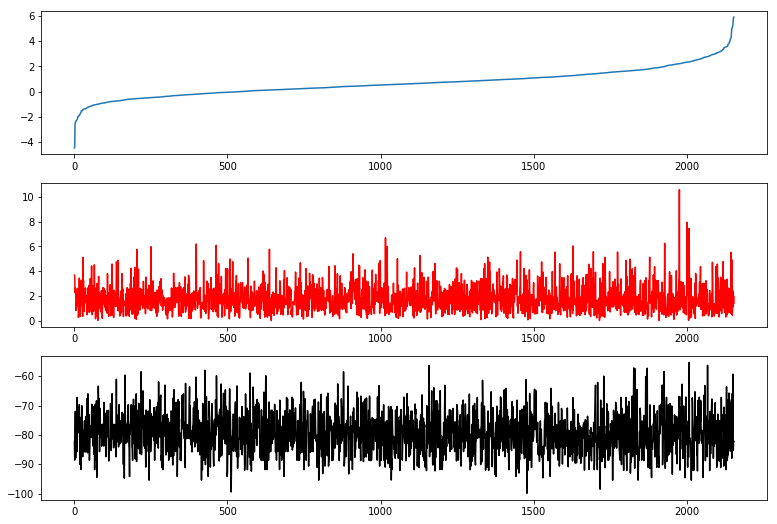

In [87]:
qmean_march, corr_march, qcorr_march = sort_vars(marchh)

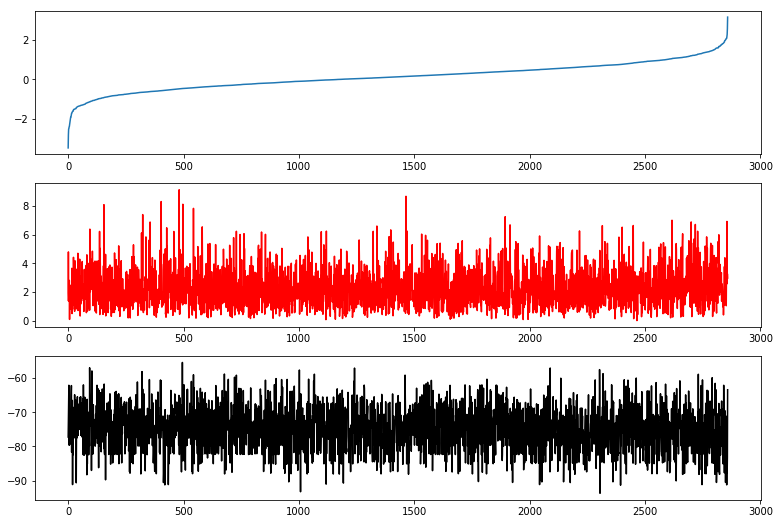

In [88]:
qmean_oct, corr_oct, qcorr_oct = sort_vars(octt)

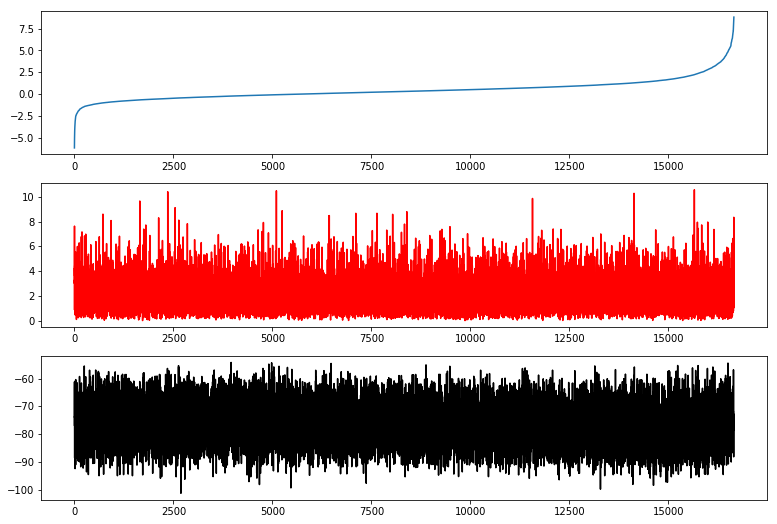

In [89]:
qmean_all, corr_all, qcorr_all = sort_vars(era_new)

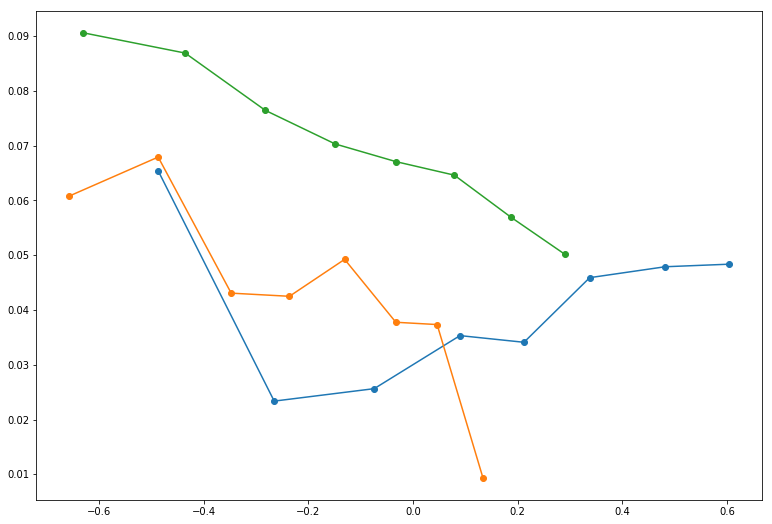

In [90]:
plt.figure(figsize=(13,9))
plt.plot(np.array(qmean_march),corr_march, '-o')
plt.plot(np.array(qmean_oct),corr_oct, '-o')
plt.plot(np.array(qmean_all),corr_all, '-o')

In [91]:
def sort_vars(dic):
    q925 = np.array(dic['q925'])
    q925s = np.array(dic['q925_s'])
    
    udic = get_col(dic['u_col'])
    vdic = get_col(dic['v_col'])
    
    ushear = (np.array(udic['high'])-np.array(udic['low']))
    vshear = (np.array(vdic['high'])-np.array(vdic['low']))
    shearss = u_met.u_v_to_ws_wd(ushear, vshear)
    shears = shearss[0] #np.array(dic['u650']) - np.array(dic['u925']) #shearss[0]
    
    
    q925 = (q925s-q925) #np.array(qdics['high'])-np.array(qdic['high'])#
    sort = np.argsort(q925)
    q = q925[sort]*1000
    shear = shears[sort]
    tmin = np.array(dic['tmin'])[sort]
    linsp = np.linspace(0,len(q)-1,15)
    
    inds = np.round(linsp).astype(int)
    #ipdb.set_trace()
    f=plt.figure(figsize=(13,9))
    ax = f.add_subplot(311)
    plt.plot(q)
    #plt.ylim(8,18)
    ax = f.add_subplot(312)
    plt.plot(shear,'r')
    ax = f.add_subplot(313)
    plt.plot(tmin,'k')
    
    plt.show()
    
    qmean = []
    corr = []
    qcorr = []
    
    for start,end in enumerate(inds[2::]):  #
        #ipdb.set_trace()
        qmean.append(np.median(q[start:end]))
#         corr.append(stats.pearsonr(shear[start:end],tmin[start:end])[0])    
#         qcorr.append(stats.pearsonr(shear[start:end],q[start:end])[0])  

        ttslope, intercept, rc, p, std_err = linregress(shear[start:end],tmin[start:end])    
        ccslope, intercept, rt, p, std_err = linregress(q[start:end], shear[start:end])
        corr.append(ttslope) 
        qcorr.append(ccslope) 
    return qmean, corr, qcorr

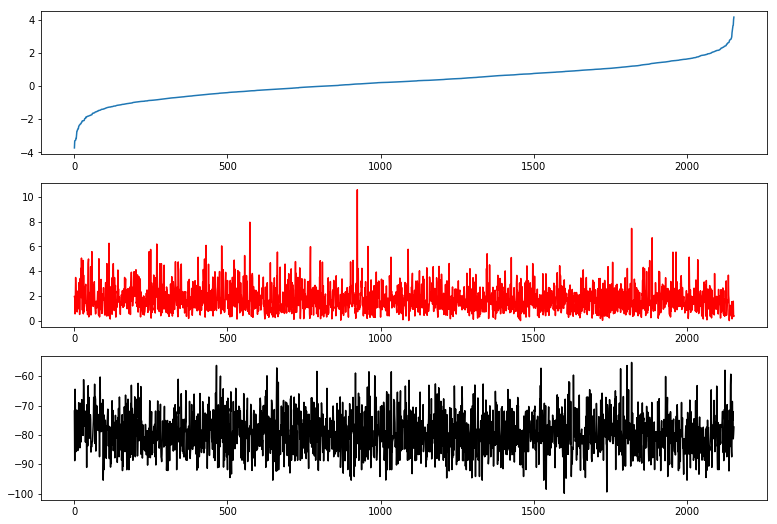

In [92]:
qmean_march, corr_march, qcorr_march = sort_vars(marchh)

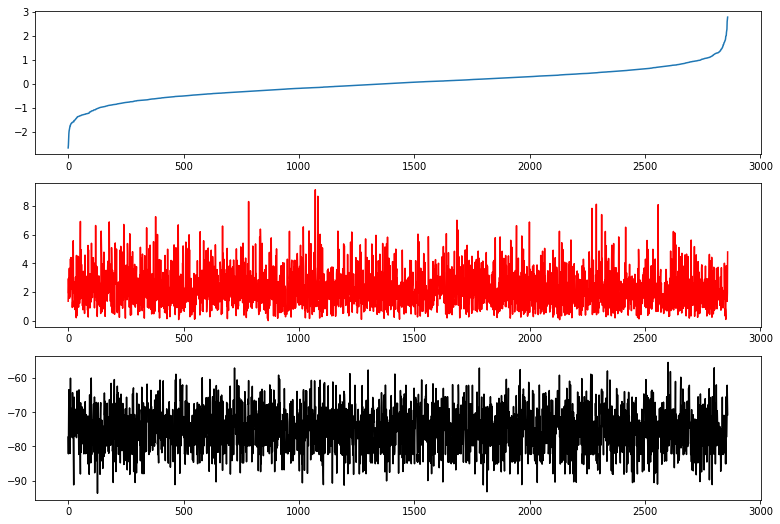

In [93]:
qmean_oct, corr_oct, qcorr_oct = sort_vars(octt)

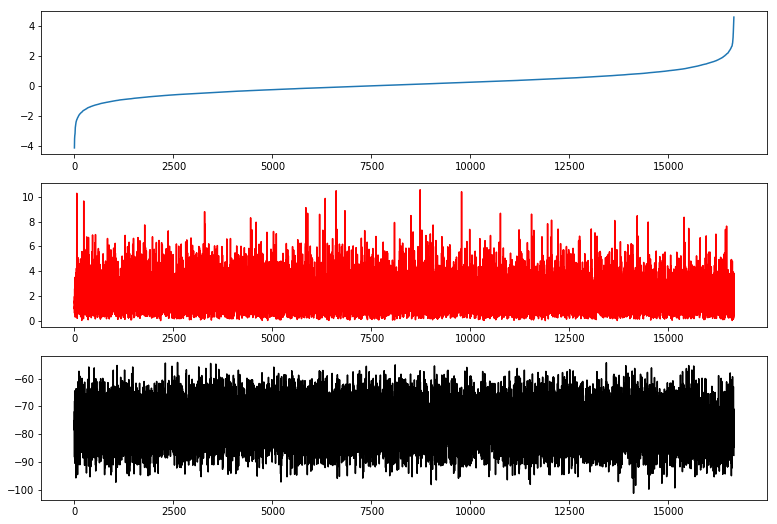

In [94]:
qmean_all, corr_all, qcorr_all = sort_vars(era_new)

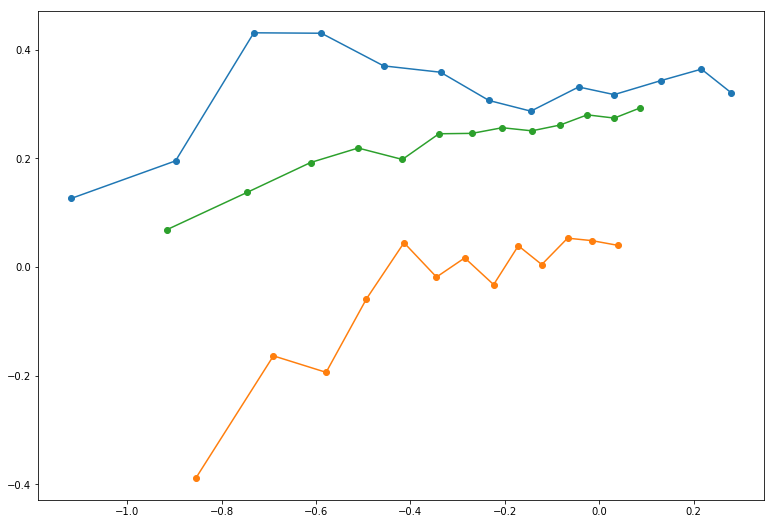

In [95]:
plt.figure(figsize=(13,9))
plt.plot(np.array(qmean_march),corr_march, '-o')
plt.plot(np.array(qmean_oct),corr_oct, '-o')
plt.plot(np.array(qmean_all),corr_all, '-o')